In [1]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import json
import matplotlib.pyplot as plt
%matplotlib inline
# open input file: 
ifile = open('C:\\Users\\Alexandros Ntzoufas\\Desktop\\MSC in BA\\3) Spring\\Big data contect analytics\\Projects Guide\\xaa.json', encoding='utf8') 

# read the first 100k entries
# set to -1 to process everything
stop = 100000
all_data = list()
for i, line in enumerate(ifile):
    if i%10000==0:
        print(i)
    if i==stop:
        break    
    # convert the json on this line to a dict
    data = json.loads(line)
    # extract what we want
    review_id=data['review_id']
    user_id=data['user_id']
    text = data['text']
    stars = data['stars']
    # add to the data collected so far
    all_data.append([review_id, user_id, stars, text])
# create the DataFrame
df = pd.DataFrame(all_data, columns=['review_id','user_id','stars','text'])
print(df)

ifile.close()


df['sentiment']=""
df.loc[df['stars']==1, ['sentiment']]='negative' 
df.loc[df['stars']==2, ['sentiment']]='negative'
df.loc[df['stars']==3, ['sentiment']]='neutral'
df.loc[df['stars']==4, ['sentiment']]='posotive'
df.loc[df['stars']==5, ['sentiment']]='posotive'

df= df.drop(['review_id', 'user_id', 'stars'], axis=1)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
                    review_id                 user_id  stars  \
0      Q1sbwvVQXV2734tPgoKj4Q  hG7b0MtEbXx5QzbzE6C_VA    1.0   
1      GJXCdrto3ASJOqKeVWPi6Q  yXQM5uF2jS6es16SJzNHfg    5.0   
2      2TzJjDVDEuAW6MR5Vuc1ug  n6-Gk65cPZL6Uz8qRm3NYw    5.0   
3      yi0R0Ugj_xUx_Nek0-_Qig  dacAIZ6fTM6mqwW5uxkskg    5.0   
4      11a8sVPMUFtaC7_ABRkmtw  ssoyf2_x0EQMed6fgHeMyQ    1.0   
5      fdiNeiN_hoCxCMy2wTRW9g  w31MKYsNFMrjhWxxAb5wIw    4.0   
6      G7XHMxG0bx9oBJNECG4IFg  jlu4CztcSxrKx56ba1a5AQ    3.0   
7      8e9HxxLjjqc9ez5ezzN7iQ  d6xvYpyzcfbF_AZ8vMB7QA    1.0   
8      qrffudO73zsslZbe8B9D3Q  sG_h0dIzTKWa3Q6fmb4u-g    2.0   
9      RS_GTIT6836bCaPy637kNQ  nMeCE5-xsdleyxYuNZ_7rA    3.0   
10     kbtscdyz6lvrtGjD1quQTg  FIk4lQQu1eTe2EpzQ4xhBA    4.0   
11     -I5umRTkhw15RqpKMl_o1Q  -mA3-1mN4JIEkqOtdbNXCQ    1.0   
12     Z7wgXp98wYB57QdRY3HQ3w  GYNnVehQeXjty0xH7-6Fhw    4.0   
13     qlXw1JQ0UodW7qrmVgwCXw  bAhqAPoWaZ

In [2]:
from nltk.corpus import stopwords

df = df.reset_index(drop=True)
replace_by_space = re.compile('[/(){}\[\]\|@,;]')
exclude_bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = replace_by_space.sub(' ', text) # replace by spac 
    text = exclude_bad_symbols.sub('', text) # remove symbols  
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in stopwords) # remove stopwors 
    return text
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')


In [3]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 137484 unique tokens.


In [4]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (100000, 250)


In [5]:
Y = pd.get_dummies(df['sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (100000, 3)


In [6]:
import pandas as pd
Y = pd.get_dummies(df['sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (100000, 3)


In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(90000, 250) (90000, 3)
(10000, 250) (10000, 3)


In [ ]:
X_train

In [8]:
from keras.layers import Activation, Dense
from keras.models import Sequential
from keras import layers
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()




Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 246, 128)          64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 5,065,451
Trainable params: 5,065,451
Non-trainable params: 0
_________________________________________________________________


In [9]:
from keras.models import Sequential
from keras.layers import Embedding
from keras import layers
from keras.layers.core import Dense, SpatialDropout1D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

epochs = 15
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 81000 samples, validate on 9000 samples
Epoch 1/15
81000/81000 [==============================] - 245s 3ms/step - loss: 0.4557 - acc: 0.8237 - val_loss: 0.3762 - val_acc: 0.8539
Epoch 2/15
81000/81000 [==============================] - 241s 3ms/step - loss: 0.2735 - acc: 0.8956 - val_loss: 0.3997 - val_acc: 0.8429
Epoch 3/15
81000/81000 [==============================] - 235s 3ms/step - loss: 0.1337 - acc: 0.9544 - val_loss: 0.4832 - val_acc: 0.8497
Epoch 4/15
81000/81000 [==============================] - 245s 3ms/step - loss: 0.0488 - acc: 0.9864 - val_loss: 0.5960 - val_acc: 0.8369488 - 
Epoch 5/15
81000/81000 [==============================] - 245s 3ms/step - loss: 0.0165 - acc: 0.9962 - val_loss: 0.7266 - val_acc: 0.8316
Epoch 6/15
81000/81000 [==============================] - 240s 3ms/step - loss: 0.0052 - acc: 0.9991 - val_loss: 0.8394 - val_acc

In [16]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

10000/10000 [==============================] - 7s 731us/step
Test set
  Loss: 0.919
  Accuracy: 0.831


In [12]:
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9837
Testing Accuracy:  0.8364


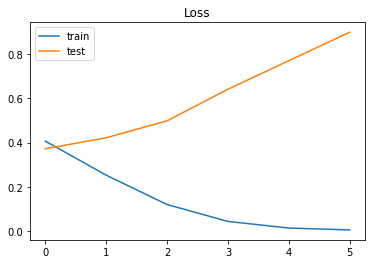

In [17]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

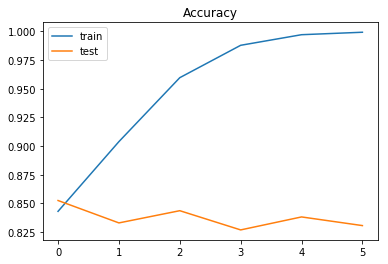

In [18]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
Y_test_pred = model.predict_classes(X_test)
conf_mat = confusion_matrix(Y_test.argmax(axis=1),
                            Y_test_pred)

pd.DataFrame(conf_mat)

,0,1,2
0,1695,297,202
1,199,481,436
2,135,419,6136


In [21]:
print(classification_report(Y_test.argmax(axis=1),
                            Y_test_pred,
                            digits=4))

              precision    recall  f1-score   support

           0     0.8354    0.7726    0.8027      2194
           1     0.4018    0.4310    0.4159      1116
           2     0.9058    0.9172    0.9115      6690

   micro avg     0.8312    0.8312    0.8312     10000
   macro avg     0.7143    0.7069    0.7100     10000
weighted avg     0.8341    0.8312    0.8323     10000

